# Constraint Programming

Constraint programming (CP) is a paradigm for solving real-world decision problems, identifying a feasible solution out of a large set of candidate solutions. CP is focused on feasibility rather than optimization, i.e. the goal is to find a feasible solution, rather an optimal solution to the given problem.  

A constraint program, or constraint satisfaction problem (CSP), is represented by:
- A state, using a set of variable assignments
- Conditions for that state to be a solution, using a set of constraints on the variables 

Constraints specify the properties of the solution to be found, rather than an allowable action or sequence of steps.

### Formulating a CSP

A CSP is defined by triple $<V, D, C>$, where:
- $V = \{v_1, v_2, …, v_n\}$ is the set of variables in the problem
- $D = \{D_1, D_2, …, D_n\}$ is the set of domains of each variable where $D_i$ is the domain of variable $V_i$
- $C = \{C_1, C_2, …, C_m\}$ is a set of constraints. $C_i = <S_i,R_i>$ specifies the allowable variable assignments, where Scope $S_i$ is a subset of variables V and Relation $R_i$ is a set of assignments to $S_i$.  

The output (or solution) to the CSP is a full assignment to $V$, from elements of $V$’s domain, such that all constraints in $C$ are satisfied. An example CSP would be designing an aircraft, where the variables include wing aspect ratio {small, medium, large}, engine {one, two, three, four}, cabin size {long&wide, long&narrow, medium&wide, medium&narrow}, and material {aluminium, titanium, composite}, and the constraints could be (1) must seat 300 people, (2) must fly at least 10,000 km, (3) must reach cruising speed of 450 knots, and (4) must have at least 20% lower fuel consumption than current models. The output would provide a feasible aircraft design which satisfies these constraints. 

Good encoding is essential for effective CSP. The possible variables and domains must be considered when formulating constraints, and consideration given to the overall size for encoding the problem. For example, consider the problem of placing 4 queens on a 4 x 4 chessboard such that no queen can attack each other. The variables are the 16 different chessboard squares, the domains for each variable are {queen 1, queen 2, queen 3, queen 4, blank}, and the constraint is that no queens can be on the same horizontal, vertical or diagonal line of the chessboard. An efficient way of encoding this constraint is to assume every queen is in a separate columns  (i.e. $Q_i < > Q_j$) and consequently determine which row each queen needs to be in, so all queens are described as $Q_1$, $Q_2$, $Q_3$, $Q_4$ on separate columns.

Constraint programming has several advantages over alternative planning methods. A model can be made more rich (i.e. more constraints added) without needing to change the fundamental structure of the CSP, and CSP allows for each constraint to be encapsulated in the formulation. CSP uses expressive language for formulating constraints and constraints interact naturally and guide the construction of the solution. Unfortunately, constraint programming can be slow to find a solution, and the user has no fine control over the solving. This can be addressed by using a low-level library like gecode. 

### The Vehicle Routing Problem - a classical CSP
The Vehicle Routing Problem (VRP) is a classical example of a constraint programming problem. The generic vehicle routing problem is traditonally described as the following:

Given a set of customers, and a fleet of vehicles to make deliveries, find a set of routes that services all customers at minimum cost. 

For each customer we know:
the quantity required, and the cost of travel from this customer to every other customer

For the vehicle fleet, we know:
the number of vehicles, and the capacity

The goal is to determine which customers each vehicle will serve and in what order, in order to deliver everything required and minimize cost. 

For this project, we will be solving the following VRP: You’ve been hired by the Generic Space Empire, assigned to a space station. Maintenance personnel have noticed malfunction at several workstations around the space station. These workstations must be investigated by  your fleet of droids, to make observations to determine faulty components.  The goal is to determine which subset of workstations each droid will visit, and in which order, ensuring each workstation is visited at least once and that the time taken to visit all workstations is minimized. 

### Encoding the VRP as a CSP
The VRP has the following inputs and outputs:

Given:
The depot where all droids must begin and end, at location (0,0)

Input:
 - $K$: number of droids
 - $N$: number of workstations
 - Capacity: maximum load of each droid
 - Distances: the distance of each workstation to every other workstation and the depot
 - Demand: the load a node will add to a visiting droid

Constraints:
 - Each node is visited once and only once
 - A droid's load will increase by the demand of any node it visits
 - A droid's load cannot exceed Capacity

Objective:
 - Minimize total travel distance
 
Output:
 - Sequence of locations (routes) for each droid to minimize the time such that each location is visited at least once. 

Decision variables:

 - $x$: a $N+1$ by $N+1$ matrix that encodes path segments. If a path segment exists starting at node $i$ and ending at node $j$, then $x[i,j] = 1$, otherwise x is 0. This matrix is $N+1$ by $N+1$ to include the depot, which is the only node that can have multiple paths entering and exiting it.
 - $u$: a $N$ by 1 array that stores the weight of a robot after visiting a node. We need this to keep track of the load of each robot to ensure its capacity is not exceeded. The array only needs to be $N$ by 1 since each node is visited exactly once!
 
Objective function: 
 - Minimize $x[i,j]$ $\times$ Distances$[i,j]$ for every $(i,j)$



### Example MiniZinc model

```
% Source: Jakob Puchinger, https://github.com/MiniZinc/minizinc-benchmarks/blob/master/vrp/vrp.mzn

    % The number of Nodes, Node 0 corresponds to the depot
int: N;
    % Vehicle capacity
int: Capacity;
    % Maximum number of vehicles
int: K;    
    % Demand at Node
array[1..N] of int: Demand;
    % Distances between the nodes
array[1..N+1, 1..N+1] of int: Distance;
    % Decision variables, is arc ij part of a route?
array[0..N, 0..N] of var 0..1: x;
    % Additional variables representing the load of vehicle after visiting
    % node i for subtour elimination
array[1..N] of var 0..Capacity: u;

    % Make sure each node (except the depot) has exactly one path coming into it
constraint
    forall(j in 1..N)(
        sum(i in 0..N)(x[i, j]) = 1
    );
    
    % Make sure each node (except the depot) has exactly one path coming out of it
constraint
    forall(i in 1..N)(
        sum(j in 0..N)(x[i, j]) = 1
    );

    % Make sure the depot has no more than K (the number of droids) paths going into it
constraint
    sum(i in 0..N)(x[i, 0]) <= K;

    % Make sure the depot has no more than K (the number of droids) paths coming out of it
constraint
    sum(j in 0..N)(x[0, j]) <= K;

    % Subtour elimination (Miller, Tucker Zemlin)
constraint
    % the weight after visiting j must be larger than weight after visiting i by at 
    % least demand[j] amount, if ij is a segment. this models the fact that you must pick up 
    % at the nodes, prevents infinite traversal
    % one would expect that the weight from i to j, if the segment exists, would go up by
    % exactly Demand[j], and not by a range of values (at least Demand[j]). The model is done 
    % this way so that the constraint is always satisfied when nodes that are not connected, since
    % they may have any difference. However, by virtue of specifying "indomain_min" in the solve annotation,
    % all the weights in u only ever increase by Demand[j]
    forall( i in 1..N, j in 1..N)(
        u[i] - u[j] + Capacity * x[i, j] <= Capacity - Demand[j]
    )
    % places a tighter bottom bound on u. assuming /\ is an and symbol, why does it need to be anded instead of as another constraint?
    /\ forall(i in 1..N)(
        Demand[i] <= u[i]
    );

% minimize the distance!
var int: objective = 
    sum( i in 0..N, j in 0..N ) (Distance[i+1, j+1] * x[i, j]); 

%page 90 of the minizinc handbook
% the double colon indicates a solve annotation: we are telling the solver what space to search (ints), what the
% decision variables are (every element of x and u), which variable to start with ("first_fail" indicates it starts
% with the variable with the smallest domain), what to initially assign to that variable ("indomain_min" starts with % smallest value in the domain)
solve 
    :: int_search(u ++ [x[i, j] | i in 1..N, j in 1..N],
        first_fail, indomain_min, complete) 
    minimize objective;

output [
    "x = ", show(x), "\n",
    "objective = ", show(objective),"\n"
];
```

### Variable Assignments for the Example MiniZinc Model

```
N = 15;
K = 8;
Capacity = 35;
Demand = [19, 30, 16, 23, 11, 31, 15, 28, 8, 8, 7, 14, 6, 19, 11];
Distance = [| 0, 14, 21, 33, 22, 23, 12, 22, 32, 32, 21, 28, 30, 29, 31, 30
| 14, 0, 12, 19, 12, 24, 12, 19, 21, 27, 7, 19, 16, 21, 33, 17
| 21, 12, 0, 15, 22, 16, 11, 9, 12, 15, 11, 29, 19, 9, 24, 23
| 33, 19, 15, 0, 21, 31, 25, 23, 8, 24, 12, 25, 9, 17, 37, 16
| 22, 12, 22, 21, 0, 36, 24, 30, 26, 37, 12, 7, 13, 30, 44, 9
| 23, 24, 16, 31, 36, 0, 13, 8, 25, 13, 26, 43, 35, 16, 8, 39
| 12, 12, 11, 25, 24, 13, 0, 10, 23, 20, 16, 31, 26, 17, 21, 28
| 22, 19, 9, 23, 30, 8, 10, 0, 18, 10, 19, 37, 28, 9, 15, 32
| 32, 21, 12, 8, 26, 25, 23, 18, 0, 17, 15, 32, 17, 10, 31, 23
| 32, 27, 15, 24, 37, 13, 20, 10, 17, 0, 25, 44, 31, 7, 16, 37
| 21, 7, 11, 12, 12, 26, 16, 19, 15, 25, 0, 19, 10, 18, 34, 13
| 28, 19, 29, 25, 7, 43, 31, 37, 32, 44, 19, 0, 16, 37, 51, 10
| 30, 16, 19, 9, 13, 35, 26, 28, 17, 31, 10, 16, 0, 24, 43, 6
| 29, 21, 9, 17, 30, 16, 17, 9, 10, 7, 18, 37, 24, 0, 21, 30
| 31, 33, 24, 37, 44, 8, 21, 15, 31, 16, 34, 51, 43, 21, 0, 47
| 30, 17, 23, 16, 9, 39, 28, 32, 23, 37, 13, 10, 6, 30, 47, 0
|];

```

In [92]:
# installation for mac
# download minizinc here: https://www.minizinc.org/software.html
# add this to your terminal config file (eg .bashrc) so that python and jupyter know where the minizinc binary is:
#      export PATH=/Applications/MiniZincIDE.app/Contents/Resources:$PATH
# then install the python wrapper for minizinc:
#      sudo pip install iminizinc
%reload_ext iminizinc

# gotta do this otherwise we run into an issue with asyncio. according to all my googling this problem
# should've been resolved as of the most recent version of ipython - alas it still broke.
import asyncio
import nest_asyncio
nest_asyncio.apply()

<IPython.core.display.Javascript object>

MiniZinc to FlatZinc converter, version 2.3.2, build 81752817
Copyright (C) 2014-2019 Monash University, NICTA, Data61


In [106]:
# import minizinc
from minizinc import Instance, Model, Solver
import pymzn
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.lines import Line2D

def solve_vrp():
    # Create the model
    vrp_model = Model("./vrp_benchmark.mzn")
    vrp_model.add_file("./vrp_variables.dzn")
    # Find the MiniZinc solver configuration for Gecode
    gecode = Solver.lookup("gecode")
    # make an instance of the problem model
    instance = Instance(gecode, vrp_model)
    return instance.solve()
    
vrp_result = solve_vrp()


In [ ]:
def find_path_from_matrix(start_node, matrix):
    # find paths that start from the depot (node 0) to the start_node, and end at the depot
    # return a list of lists of nodes, each list starts and ends at 0
    path = [0, start_node]
    cur_node = start_node
    while cur_node != 0:
        cur_node = matrix[cur_node].index(1)
        path.append(cur_node)
    return path

### The solution to the droid workstation VRP

[[0, 1, 0], [0, 2, 0], [0, 5, 9, 3, 0], [0, 6, 0], [0, 11, 4, 0], [0, 13, 8, 0], [0, 14, 7, 0], [0, 15, 12, 10, 0]]
[19, 30, 35, 30, 11, 31, 34, 34, 19, 33, 7, 25, 6, 19, 11] 15


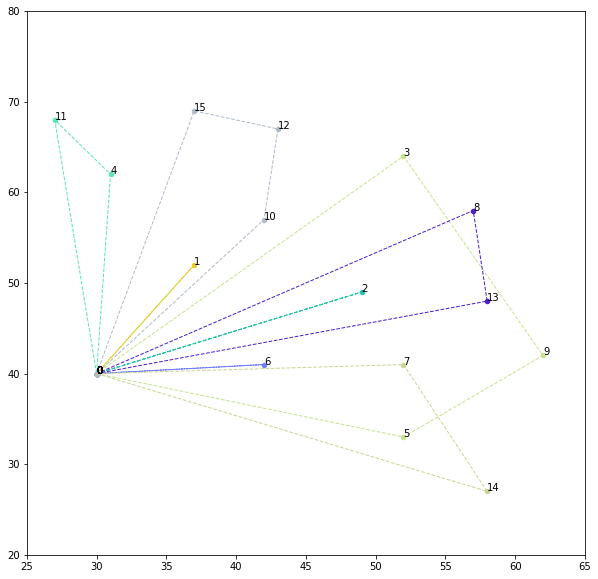

In [105]:
# node coordinates from http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances//P/P-n16-k8.vrp
node_coords = dict()
with open("./vrp_node_coords", "r") as f:
    for line in f.read().splitlines():
        s = line.split()
        node_coords[int(s[0])-1] = (int(s[1]), int(s[2]))

path_matrix = vrp_result['x']
node_paths = []
# to find the paths, start at the depot and traverse the nodes that connect from the depot
for i in range(len(path_matrix[0])):
    if path_matrix[0][i] > 0:
        node_paths.append(find_path_from_matrix(i, path_matrix))
# let's display the paths

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplots(111)
for path in node_paths:
    xs = [node_coords[i][0] for i in path]
    ys = [node_coords[i][1] for i in path]
    color=(random.random(), random.random(), random.random())
    ax.add_line(Line2D(xs, ys, color=color, linewidth=1, ls="--"))
    ax.scatter(xs, ys, color=color, s=20)
    for i in path:
        ax.annotate(i, (node_coords[i][0], node_coords[i][1]))
ax.set_xlim(25, 65)
ax.set_ylim(20, 80)
plt.show()

### Finding All Optimal Solutions

Now that we have the optimal distance, we can use a satisfy solver to find other optimal solutions. We make slight adjustments to the model, given below:

```
% Source: Jakob Puchinger, https://github.com/MiniZinc/minizinc-benchmarks/blob/master/vrp/vrp.mzn
    % The number of Nodes, Node 0 corresponds to the depot
int: N;
    % Vehicle capacity
int: Capacity;
    % Maximum number of vehicles
int: K;    
    % Demand at Node
array[1..N] of int: Demand;
    % Distances between the nodes
array[1..N+1, 1..N+1] of int: Distance;
    % Decision variables, is arc ij part of a route?
array[0..N, 0..N] of var 0..1: x;
    % Additional variables representing the load of vehicle after visiting
    % node i for subtour elimination
array[1..N] of var 0..Capacity: u;

    % Indegree constraints
constraint
    forall(j in 1..N)(
        sum(i in 0..N)(x[i, j]) = 1
    );
    
    % Outdegree constraints
constraint
    forall(i in 1..N)(
        sum(j in 0..N)(x[i, j]) = 1
    );

    % Indegree Depot
constraint
    sum(i in 0..N)(x[i, 0]) <= K;

    % Outdegree Depot
constraint
    sum(j in 0..N)(x[0, j]) <= K;

    % Subtour elimination (Miller, Tucker Zemlin)
constraint
    
    forall( i in 1..N, j in 1..N)(
        u[i] - u[j] + Capacity * x[i, j] <= Capacity - Demand[j]
    )
    /\ forall(i in 1..N)(
        Demand[i] <= u[i]
    );

var int: objective = 
    sum( i in 0..N, j in 0..N ) (Distance[i+1, j+1] * x[i, j]); 
    
constraint objective = 450;

solve 
    :: int_search(u ++ [x[i, j] | i in 1..N, j in 1..N],
        first_fail, indomain_min, complete) 
    satisfy;

output [
    "x = ", show(x), "\n",
    "objective = ", show(objective),"\n"
];
```

we ran the following command in the terminal
`     minizinc --solver gecode --all-solutions vrp_benchmark_all_optimal.mzn vrp_variables.dzn`
to find other optimal routes. Did not run to completion since it takes VERY long, but here are some of the results

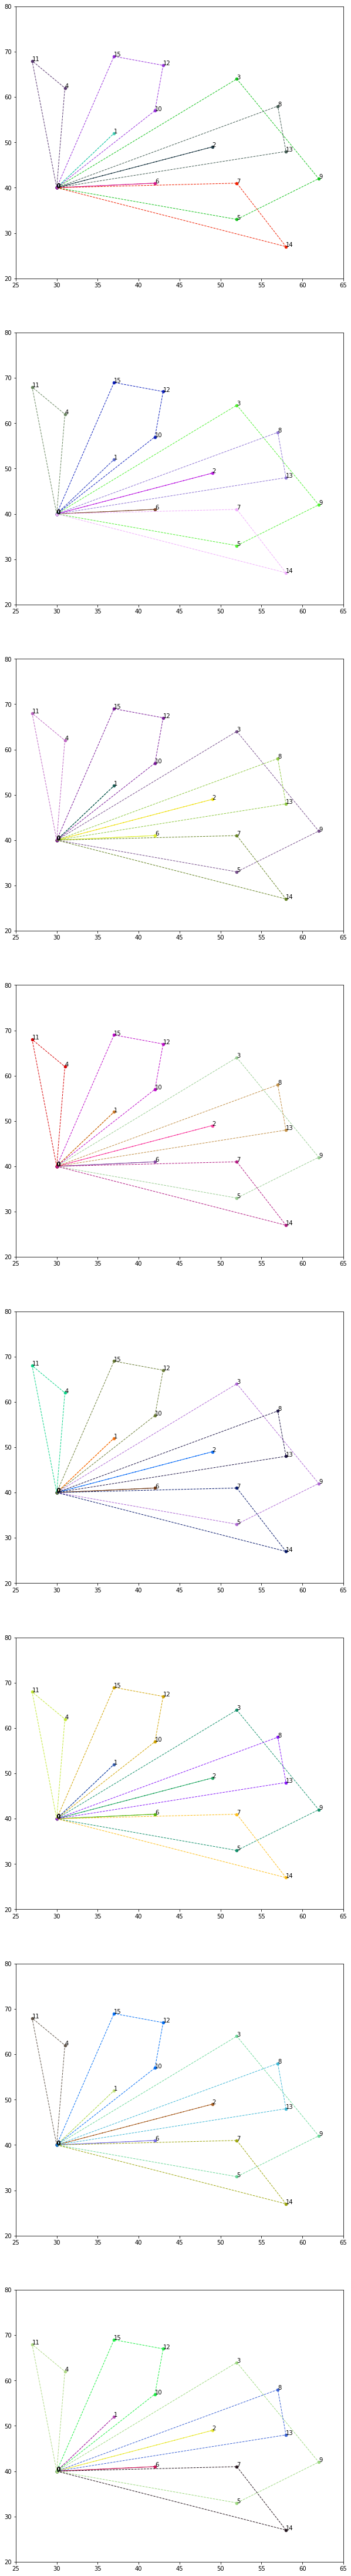

In [121]:
# as it turns out, it finds more than one optimal path but they are all just different orderings of the same path. 
# If we ran it longer we'd probably find the solution given on the website.

results_flattened = [[0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                     [0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                     [0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                     [0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                     [0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
fig, axs = plt.subplots(len(results_flattened))
fig.set_size_inches(10,10*len(results_flattened))

ax_i = 0
for result in results_flattened:
    result_2d = [result[i:i+16] for i in range(0,len(result),16)]
    node_paths = []
    # to find the paths, start at the depot and traverse the nodes that connect from the depot
    for i in range(len(result_2d[0])):
        if result_2d[0][i] > 0:
            node_paths.append(find_path_from_matrix(i, result_2d))
    for path in node_paths:
        xs = [node_coords[i][0] for i in path]
        ys = [node_coords[i][1] for i in path]
        color=(random.random(), random.random(), random.random())
        axs[ax_i].add_line(Line2D(xs, ys, color=color, linewidth=1, ls="--"))
        axs[ax_i].scatter(xs, ys, color=color, s=20)
        for i in path:
            axs[ax_i].annotate(i, (node_coords[i][0], node_coords[i][1]))
        axs[ax_i].set_xlim(25, 65)
        axs[ax_i].set_ylim(20, 80)
    ax_i += 1
plt.show()


## Summary

In this notebook, we give an overview of constraint programming. We explain that constraint programming is a rich formulation that allows us to solve planning problems at a high level. It allows us to specify rules which give us a set of feasible solutions, and to easily extend these rules if we wish to refine these solutions. 

We describe the idea behind the vehicle routing problem, a problem commonly used as a constraint programming benchmark meant to model a set of vehicles that must make a certain set of deliveries. We give a minizinc encoding that would allow one to solve arbitrary vehicle routing problems. Finally, we run our minizinc model using gecode to generate a bunch of feasible solutions that were all the same length as the solution given to us. We note that the solutions seem to be permutations of each other -- the robots take the same paths but in different orderings.